# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [18]:
import time
import math
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


In [19]:
# Import all of the methods that we will need.
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data represents 17 marketing campaigns.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [20]:
# Read in the data.
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [21]:
# Take a look at a sample of the data.
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [22]:
# Check to see what datatypes there are and if there are any missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [23]:
# Enumerate all of the catagories and their values.
obj_col = df.select_dtypes(include='object')
print('Categorical Values:')
for col in obj_col:
    print(col, df[col].nunique(), df[col].unique())
    print()

Categorical Values:
job 12 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital 4 ['married' 'single' 'divorced' 'unknown']

education 8 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default 3 ['no' 'unknown' 'yes']

housing 3 ['no' 'yes' 'unknown']

loan 3 ['no' 'yes' 'unknown']

contact 2 ['telephone' 'cellular']

month 10 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week 5 ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome 3 ['nonexistent' 'failure' 'success']

y 2 ['no' 'yes']



In [24]:
# Examine the count of each catagorical value.
for col in obj_col:
    print(col, df[col].value_counts())
    print()

job job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

marital marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

education education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

default default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

housing housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

loan loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

contact contact
cel

In [25]:
# There are only a small # of unknown job types and unknown marital statae.  Let's drop these.
df = df[df['job'] != 'unknown']
df = df[df['marital'] != 'unknown']

# There are only 3 defaults, so this column is of no value and should be dropped.
df.drop(['default'], axis=1, inplace=True)


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [26]:
# Recheck the count now that we have dropped some roles.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40787 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40787 non-null  int64  
 1   job             40787 non-null  object 
 2   marital         40787 non-null  object 
 3   education       40787 non-null  object 
 4   housing         40787 non-null  object 
 5   loan            40787 non-null  object 
 6   contact         40787 non-null  object 
 7   month           40787 non-null  object 
 8   day_of_week     40787 non-null  object 
 9   duration        40787 non-null  int64  
 10  campaign        40787 non-null  int64  
 11  pdays           40787 non-null  int64  
 12  previous        40787 non-null  int64  
 13  poutcome        40787 non-null  object 
 14  emp.var.rate    40787 non-null  float64
 15  cons.price.idx  40787 non-null  float64
 16  cons.conf.idx   40787 non-null  float64
 17  euribor3m       40787 non-null  floa

In [27]:
# Examine catagorical columns to see if the output class is dependent upon each value type.
obj_col = df.select_dtypes(include='object')
for col in obj_col:
    vals = df[col].unique()
    print()
    print(f"{col}:")
    for val in vals:
        num_true = len(df[(df[col] == val) & (df['y'] == 'yes')])
        num_false = len(df[(df[col] == val) & (df['y'] == 'no')])
        num_total = num_true + num_false
        pct_true = int(num_true / num_total *100)
        pct_false = int(num_false / num_total *100)
        print(f"{col} == {val}: {pct_true}% True, {pct_false}% False" )



job:
job == housemaid: 10% True, 89% False
job == services: 8% True, 91% False
job == admin.: 12% True, 87% False
job == blue-collar: 6% True, 93% False
job == technician: 10% True, 89% False
job == retired: 25% True, 74% False
job == management: 11% True, 88% False
job == unemployed: 14% True, 85% False
job == self-employed: 10% True, 89% False
job == entrepreneur: 8% True, 91% False
job == student: 31% True, 68% False

marital:
marital == married: 10% True, 89% False
marital == single: 13% True, 86% False
marital == divorced: 10% True, 89% False

education:
education == basic.4y: 10% True, 89% False
education == high.school: 10% True, 89% False
education == basic.6y: 8% True, 91% False
education == basic.9y: 7% True, 92% False
education == professional.course: 11% True, 88% False
education == unknown: 14% True, 85% False
education == university.degree: 13% True, 86% False
education == illiterate: 22% True, 77% False

housing:
housing == no: 10% True, 89% False
housing == yes: 11% Tr

### Impacts of Ordinal and Nominal Features
In order to understand the impact of ordinal and nominal features, we computed the term deposit rate for each of these feature's sub-groups.

For most jobs, the deposit rate is about 10%.  However, this rate is slightly higher for the unemployed (14%), students (31%), and the retired (25%).  It is slightly lower for blue-collared workers (6%).  Ergo, there is a potential to combine many of the other jobs.

The single marital status has only 3% higher deposit rate than those who are either married or divorced.  This could be within the margin of error.  Thus, marital status may not matter.

The deposit rate does not seem to vary much base on education.  The reported deposit rate drops slightly from basic 4 year (10%) to basic 6 year (7%)  and then increases to high school (10%) and then to a university degree (13%).  It doesn't make much sense that the deposit rate would drop and then rise as the level of education increased.  Thus, it is possible that these variations are within the margin of error and that there is no change in the population as a whole.  The deposit rate for the illiterate does seem to be significantly higher (22%) than for other education levels at first glance.  However, it should be noted that this is based on a small # of samples (18).  Thus, it is not significant.

It should also be noted that the acceptance rate does not vary based upon the having a personal loan, having a housing loan, or baed upon the day of the week.  Therefore, these columns should be dropped from our initial analysis.

The month data appears to be missing data for January and February.  It is not known why this is.  However, it should be noted that the deposit rate is high in September and October (~44%) as well as from December (45%) and March (50%).  We might make the assumption that January and February are 48%.  It might be possible to re-classify the month feature as Winter (Dec - Mar), Mid Spring (April), Summer (May - Aug), Early Autumn (Sept - Oct), and Late Autumn (Nov).

In [28]:
filtered_df = df.drop(['marital', 'housing', 'loan', 'day_of_week'], axis=1)

In [29]:
# According to the paper, age should be equal to or greater than 18.
# Let's consider any ages less than that to be invalid data and drop it.
print(len(filtered_df[filtered_df['age'] < 18]))
filtered_df = filtered_df[filtered_df['age'] >= 18]

# Durations above 2000 appear to be outliers, so let's drop these.
print(len(filtered_df[filtered_df['duration'] > 2000]))
filtered_df = filtered_df[filtered_df['duration'] <= 2000]

# Capaigns above 20 appear to be outliers, so we will drop these.
print(len(filtered_df[filtered_df['campaign'] > 20]))
filtered_df = filtered_df[filtered_df['campaign'] <= 20]

# Let's create a new column for prev_contacted using pdays != 999.
fdf = filtered_df.copy()
print(len(fdf[fdf['pdays'] == 999]))
fdf['prev_contacted'] = True
fdf.loc[fdf['pdays'] != 999, 'prev_contacted'] = False
fdf['pdays'] = fdf['pdays'].replace(999, 0)

# How many previous contacts are == 4, 5, 6, 7?
print(len(fdf[fdf['previous'] == 4]), len(fdf[fdf['previous'] == 5]), len(fdf[fdf['previous'] == 6]), len(fdf[fdf['previous'] == 7]))


5
58
156
39083
70 18 5 1


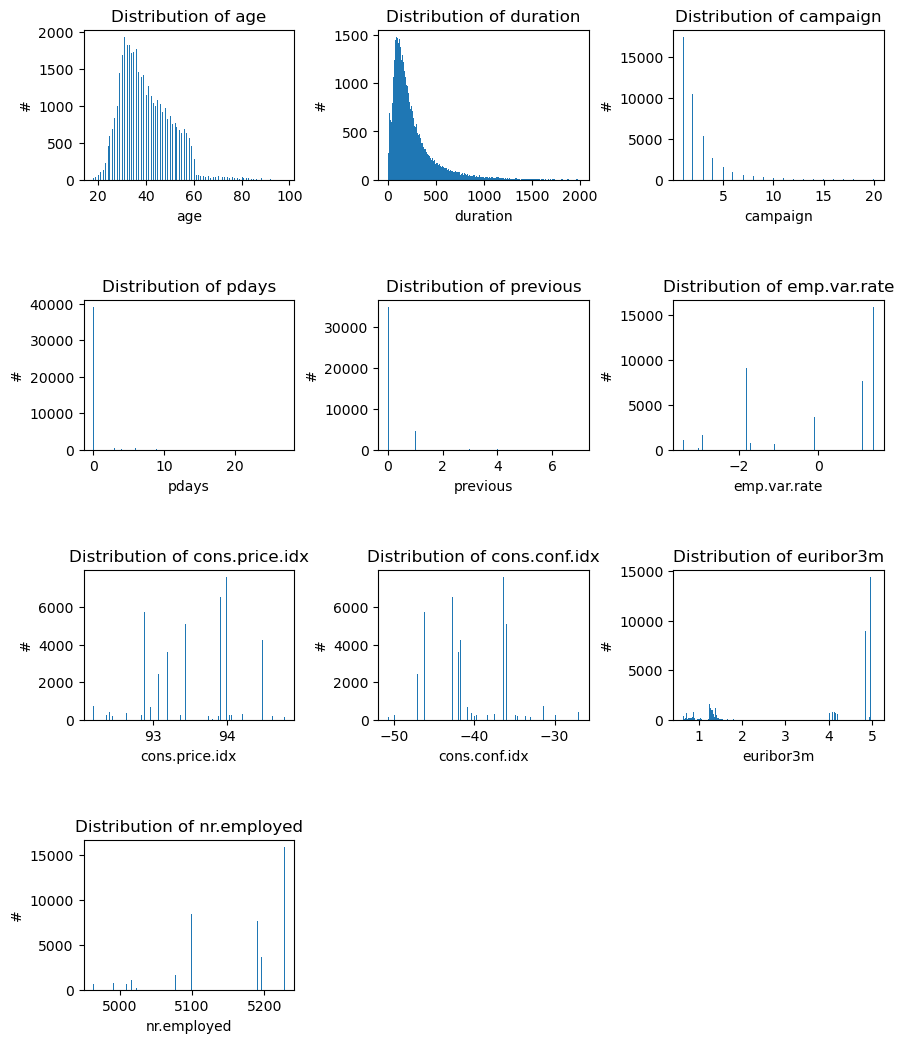

In [30]:
# Create a histogram for each numeric entry.

# # Select the numeric columns and create this # of plots
num_col = fdf.select_dtypes(include='number')
num_plots = len(num_col.columns)
num_x_plots = 3
num_y_plots = math.ceil(float(num_plots) / num_x_plots)

# # Create a figure window with a grid for all of the plots.
fig, axs = plt.subplots(num_y_plots, num_x_plots, figsize=(10, 12)) # 4 rows, 3 columns

x = y = 0
# For each numeric input
for col in num_col:
    # Plot the distribution of this variable.
    axs[y,x].hist(fdf[col], bins=200)
    axs[y,x].set_title(f"Distribution of {col}")
    axs[y,x].set_ylabel('#')
    axs[y,x].set_xlabel(f"{col}")
    # Increment the plot #.
    x+=1
    if x == num_x_plots:
        x = 0
        y+=1

# Hide the unused plots
axs[3,1].set_visible(False)
axs[3,2].set_visible(False)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.8)
plt.savefig(f"images/Distributions.jpg")
plt.show();


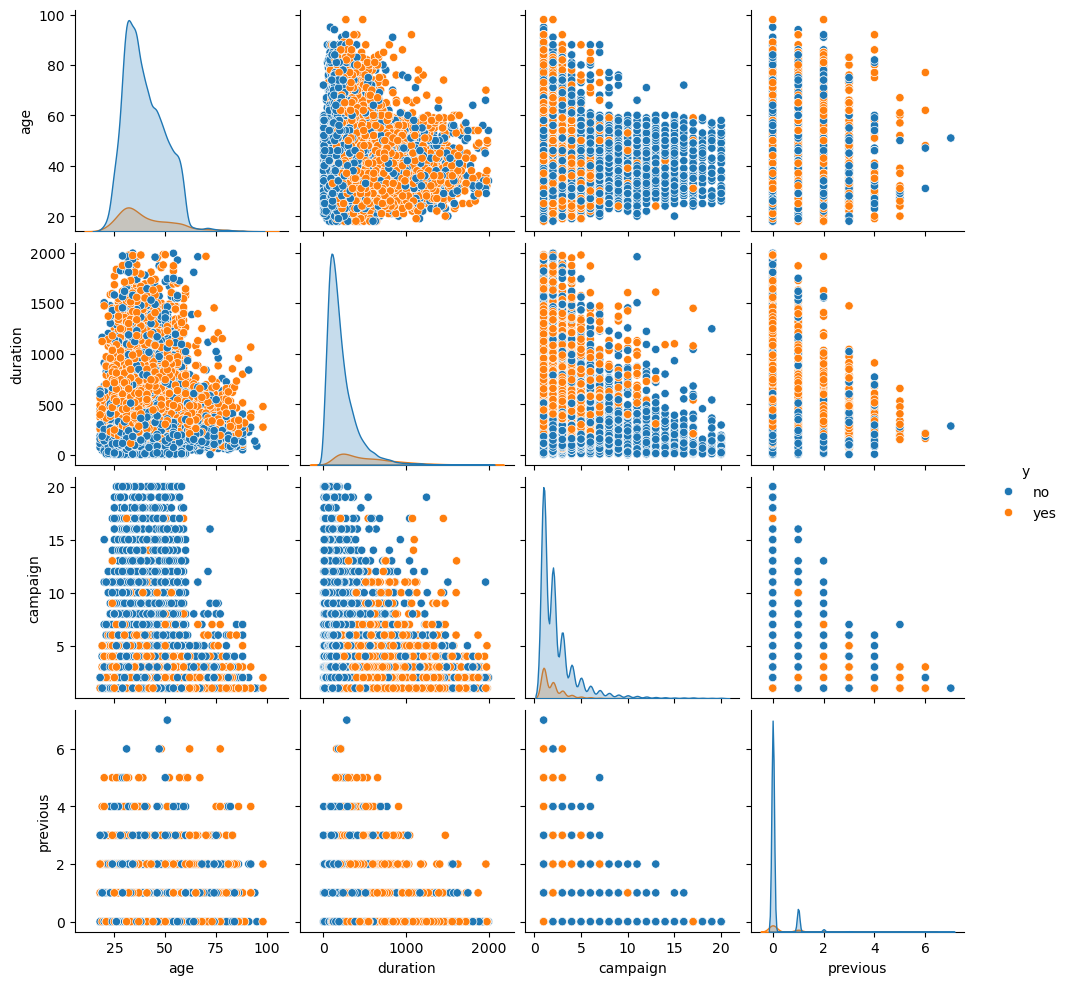

In [31]:
# Only the age, duration, campaign, and previous categories look like they may have a regular distribution.

# Create a pairplot for each of these numeric values.
pair_df = fdf[['age', 'duration', 'campaign', 'previous', 'y']]
pp = sns.pairplot(pair_df, hue="y")
pp.savefig("images/PairPlot.jpg")

The pairplot indicates some clear separability, especially for the age/duration, age/campaign, and duration/campaign plots.
The previous/campaign plot also looks like it may have some separability.
The pairplots for the other numeric variables (not shown here) do not show as much potential for separation of depositors and non-depositors.

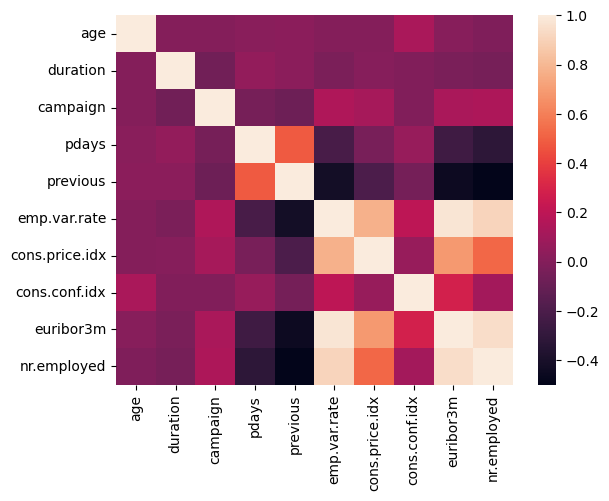

In [32]:
# Generate a correlation heatmap to see if any of these variables might be highly-correlated or redundant.
corr = fdf.select_dtypes('number').corr()
ax = sns.heatmap(corr)
fig = ax.get_figure()
fig.savefig("images/HeatMap.jpg", dpi=300, bbox_inches='tight')
plt.show()

# The nr.employed, euribor3m, and emp.var.rate are all highly correlated.
# Therefore, let's drop all but one of these columns.
# Let's keep euribor3m, since it appears to be more distributed.
fdf.drop(['emp.var.rate','nr.employed'], axis=1, inplace=True)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business objective is to build a classifier that will determine if an individual will respond to a marketing campaign for making a new term deposit.  With this classifier, a bank can collect the required data on each of its customers or potential customers and feed this data to the classifier.  The bank will then use these classifications to limit or direct their marketing campaign to a subset of customers that have a high likelyhood (much > 1%) to making a new term deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [33]:
# Separate our input and output data.
X = fdf.drop('y', axis=1)
y = fdf.y

# Transform the output data.
le = LabelEncoder()
y = le.fit_transform(y)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [34]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

We should use LogisticRegression as our baseline model.

In [35]:
# Create and fit a dummy classifier.
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Make predictions for the test data.
y_pred = dummy_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dummy Classifier Accuracy: {accuracy}")

Dummy Classifier Accuracy: 0.8873551885629776


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [36]:
# Grab the column names for each type of data.
num_col = X_train.select_dtypes(include='number').columns.tolist()
cat_col = X_train.select_dtypes(include='object').columns.tolist()
print(cat_col)

# Create an array of column transformers for each data type.
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  StandardScaler(), num_col),
        ('cat',  OneHotEncoder(), cat_col)
    ], remainder='passthrough'
)


['job', 'education', 'contact', 'month', 'poutcome']


In [37]:
results = []

# Create a pipeline
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression(max_iter=1000))
])

# Perform grid search
grid_search = GridSearchCV(base_pipe, param_grid={'logisticregression__C': [0.1, 1, 10]}, cv=5, n_jobs=-1)

# Fit the model and time it
start_time = time.time()
grid_search.fit(X_train, y_train)
base_fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

# Get the best estimator
best_model = grid_search.best_estimator_


### Problem 9: Score the Model

What is the accuracy of your model?

In [38]:
# Evaluate on training and test sets
base_train_score = best_model.score(X_train, y_train)
base_test_score = best_model.score(X_test, y_test)

# Print the results.
print(f"For LogisticRegression, the Train Score is {base_train_score} and the Test Score is {base_test_score}")

For LogisticRegression, the Train Score is 0.9106735687434523 and the Test Score is 0.9106482622627557


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [39]:

# Create an array of models and hyper-parameters.
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']})
}

def FitAndTestModels(X_train, y_train, X_test, y_test):

    results = []
    best_parms = []

    for name, (model, params) in models.items():
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            (name, model)
        ])
        
        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
        
        # Fit the model and time it
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
        
        # Get the best estimator
        best_model = grid_search.best_estimator_
        print(grid_search.best_params_)
        
        # Evaluate on training and test sets
        train_score = best_model.score(X_train, y_train)
        test_score = best_model.score(X_test, y_test)
        
        # Append the results
        results.append([name, fit_time, train_score, test_score])
        best_parms.append([name, grid_search.best_params_])

        # Grab the feature names
        feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
        print('\r\n')
        print(f'{name} ranked features:')

        # Get and print the feature rankings if available.
        if name == 'knn':
            pass

        elif name == 'logisticregression':
            coeff = best_model.named_steps[name].coef_[0]
            feature_importance_df = pd.DataFrame({'feature': feature_names, 'coeff_abs': abs(coeff).tolist()})
            ranked_features = feature_importance_df.sort_values(by='coeff_abs', ascending=False)
            print(ranked_features)

        elif name == 'decisiontreeclassifier':
            feature_importance = best_model.named_steps[name].feature_importances_
            feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
            ranked_features = feature_importance_df.sort_values(by='importance', ascending=False)
            print(ranked_features)
            
        elif name == 'svc':
            pass
        
        else:
            pass


    # Create the results DataFrame
    results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
    results_df.set_index('Model', inplace=True)

    # return values
    return results_df, best_parms

In [40]:
# Run GridSearchCV on all models using the selected data.
results_df, best_parms = FitAndTestModels(X_train, y_train, X_test, y_test)

# Save to CSV
results_df.to_csv('data/model_results_run1.csv')


{'knn__n_neighbors': 7}


knn ranked features:
{'logisticregression__C': 1}


logisticregression ranked features:
                               feature  coeff_abs
7                       num__euribor3m   1.248974
1                        num__duration   1.197420
34                      cat__month_mar   1.173013
42           remainder__prev_contacted   1.160080
35                      cat__month_may   1.091567
39               cat__poutcome_failure   0.769030
28              cat__contact_telephone   0.506011
29                      cat__month_apr   0.427685
9                 cat__job_blue-collar   0.384830
13                    cat__job_retired   0.338229
41               cat__poutcome_success   0.323856
40           cat__poutcome_nonexistent   0.281856
36                      cat__month_nov   0.274321
38                      cat__month_sep   0.262640
21             cat__education_basic.9y   0.243137
15                   cat__job_services   0.227553
5                  num__cons.price.i

### Feature Selection
#### Decision Tree Classifier
The Decision Tree Classifier indicates that the duration and employed features are the most important.
The consumer confidence index, poutcome_sucess, early autumn season, and consumer price index are the next most important features.
It also lists the campaign and pdays have some minor impact.

#### Logistic Regression
The Logistic Regression model had a different ranking of the importance of features:
The prevously contacted, duration, employed, and winter season features were the most important.
The blue colared job, contact_telephone, poutcome_failure, late autumn season, summer season, and early autumn season were the next most important.

#### Comparison of feature selection.
The DecisionTree made use of fewer features and imparted a different importance to the many features.  However, some (but not all) of the most important features appeared in both models.


In [41]:
print(results_df.sort_values(by='Test Accuracy', ascending=False))


                        Train Time  Train Accuracy  Test Accuracy
Model                                                            
decisiontreeclassifier    0.238136        0.915912       0.912620
svc                      31.204459        0.921150       0.911511
logisticregression        0.218276        0.910674       0.910648
knn                       1.222344        0.926357       0.904609


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [42]:
# Print out the parameters used for each model.
bpdf = pd.DataFrame(best_parms, columns=['Model', 'HyperParm'])
print(bpdf)

                    Model                                 HyperParm
0                     knn                   {'knn__n_neighbors': 7}
1      logisticregression              {'logisticregression__C': 1}
2  decisiontreeclassifier  {'decisiontreeclassifier__max_depth': 5}
3                     svc       {'svc__C': 1, 'svc__kernel': 'rbf'}


In [43]:
# Rather than dropping emp.var.rate and nr.employed, we can use PCA to combine them with euribor3m into one variable.
employed_df = filtered_df[['emp.var.rate', 'nr.employed', 'euribor3m']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(employed_df)
pca = PCA(n_components=1)
principal_components = pca.fit_transform(scaled_data)

# Add this new component back into the filtered data.
fdf.drop('euribor3m', axis=1, inplace=True)
fdf['employed'] = principal_components


# Combine job types that have the same or similar account opening rates, e.g. 8 - 12%.
# Combine housemaid, services, admin., technician, management, self-employed, and entrepreneur into other.
# This should limit the values to other (~10%), blue-collar (6%), retired (25%), unemployed (14%), and student (31%).
fdf['job'] = fdf['job'].replace(['housemaid', 'services', 'admin.', 'technician', 'management', 'self-employed', 'entrepreneur'], 'other')


# Drop education as it does not seem to matter much.
fdf.drop(['education'], axis=1, inplace=True)


# Combine the month data:  Winter (Dec - Mar), Mid Spring (April), Summer (May - Aug), Early Autumn (Sept - Oct), and Late Autumn (Nov).
fdf['month'] = fdf['month'].replace(['dec', 'mar'], 'winter')
fdf['month'] = fdf['month'].replace(['apr'], 'spring')
fdf['month'] = fdf['month'].replace(['may', 'jun', 'jul', 'aug'], 'summer')
fdf['month'] = fdf['month'].replace(['sep', 'oct'], 'early autumn')
fdf['month'] = fdf['month'].replace(['nov'], 'late autumn')
fdf = fdf.rename(columns={'month':'season'})


In [44]:
# Separate our input and output data.
X = fdf.drop('y', axis=1)
y = fdf.y

# Transform the output data.
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Grab the column names for each type of data.
num_col = X_train.select_dtypes(include='number').columns.tolist()
cat_col = X_train.select_dtypes(include='object').columns.tolist()
print(cat_col)

# Create an array of column transformers for each data type.
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  StandardScaler(), num_col),
        ('cat',  OneHotEncoder(), cat_col)
    ], remainder='passthrough'
)


['job', 'contact', 'season', 'poutcome']


In [46]:
# Run GridSearchCV on all models using the selected data.
results_df, best_parms = FitAndTestModels(X_train, y_train, X_test, y_test)

# Save to CSV
results_df.to_csv('data/model_results_run2.csv')


{'knn__n_neighbors': 7}


knn ranked features:
{'logisticregression__C': 10}


logisticregression ranked features:
                      feature  coeff_abs
23  remainder__prev_contacted   1.720312
1               num__duration   1.169014
7               num__employed   1.156172
19         cat__season_winter   0.983653
8        cat__job_blue-collar   0.649081
14     cat__contact_telephone   0.617110
20      cat__poutcome_failure   0.574029
16    cat__season_late autumn   0.511389
18         cat__season_summer   0.433840
15   cat__season_early autumn   0.377615
5         num__cons.price.idx   0.336266
10           cat__job_retired   0.292728
6          num__cons.conf.idx   0.248858
9              cat__job_other   0.184038
17         cat__season_spring   0.172799
22      cat__poutcome_success   0.142170
2               num__campaign   0.121937
13      cat__contact_cellular   0.105121
21  cat__poutcome_nonexistent   0.080131
3                  num__pdays   0.079672
11           cat__job_st

In [47]:
# Print the training time, training accuracy, and test accuracy.
print(results_df.sort_values(by='Test Accuracy', ascending=False))


                        Train Time  Train Accuracy  Test Accuracy
Model                                                            
decisiontreeclassifier    0.214596        0.917576       0.912867
logisticregression        0.245056        0.910365       0.910402
svc                      72.214609        0.928576       0.910402
knn                       0.968201        0.927128       0.904363


### Feature Selection Results
#### Decision Tree Classifier
The Decision Tree Classifier indicates that the duration and employed features are the most important.

The consumer confidence index, poutcome_sucess, early autumn season, and consumer price index are the next most important features.
It also lists the campaign and pdays have some minor impact.

On the second run, the priority of the confidence index and poutcome_sucess features switched.  However, the winter season now became more important than early autumn.

#### Logistic Regression
The Logistic Regression model had a different ranking of the importance of features than the Decision Tree Classifier.  However, these did not change with the feature changes that we made for the second run.

The prevously contacted, duration, employed, and winter season features were the most important.
The blue collared job, contact_telephone, poutcome_failure, late autumn season, summer season, and early autumn season were the next most important.

#### Comparison of Feature Selection
The DecisionTree made use of fewer features and imparted a different importance to the many features.  However, some (but not all) of the most important features appeared in both models.


### Next Steps
We could remove those features that none of the models found to be important.  For SVC and KNN, we could remove these columns from the data and rerun the fitting and testing.  If the test accuracy did not change for these models, we could leave these columns out.  By testing each column one at a time, we could identify which columns had little to no impact.

We would recommend to the customer to focus their marketing efforts to those who impacted any of the models.  It is likely that these models vary due to the unbalanced nature of the data.  Collecting more data might help.  By doing so, we would hope to collect for data for those feature values that were under-represented.

By marketing to those that meet our current feature ranking, we would hope to collect more data for those feature values that are under-represented but important.  With enough data for each feature value, we could preferentially select data so that each value for one feature is balanced.  Then we could rerun our models to see the importance of these feature values.
